#SHDOM single-scattering adjoint

This folder contains SHDOM files related to a high resolution simulation that was performed by Frank Evans in 2013.  The cloud field was generated with a large-eddy simulation.  SHDOM ran at 320x320xNZxNSH resolution.  The NADIR radiance of the cloud field:

![The Reflectance](./les0822nh15t13_aer008_w0.646a_idir01.jpg)


The same cloud field is used for adjoint testing in 2D.  Presently, the adjoint is working for single-scattering contributions to the misfit function derivative.  This component was tested using a 2D slice ($y=5.5\mathrm{km}$). 



In [1]:
%pylab inline

# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd



Populating the interactive namespace from numpy and matplotlib


In [2]:
ls

basic_imports.py
exploring_adjoint.ipynb
les0822nh15t13_aer008_w0.466rad.modis
les0822nh15t13_aer008_w0.466.ref
les0822nh15t13_aer008_w0.646a_idir01.jpg
les0822nh15t13_aer008_w0.646rad.modis
les0822nh15t13_aer008_w0.646.ref
les0822nh15t13_aer008_w1.632rad.modis
les0822nh15t13_aer008_w1.632.ref
notebook-check-data.ipynb
radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.adj
radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.arad
radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.log
radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss2.arad
read_modis_sim.pro


In [3]:
# Utility functions

def print_head(fname, Nlines=10, indent="\t"):
    "Print the head of the file."
    
    # Print a message and then the first N lines
    print("Showing head: {}".format(fname))
    for i, line in zip(range(Nlines), open(fname, 'r')):
        print(indent + line.strip())
        
    print('\n')
    
def read_log(flog, start_line="X      Z   Extinct", max_lines=10**8):
    """
    Read in a log file but save lines only after reaching a line 
    matching start_line.
    """
    
    # Loop over lines record after header and before footer
    ncols = None 
    lines = []
    for i, line in zip(range(max_lines), open(flog, 'r')):
        new = line.strip().split()
        
        # Check if the line is the header
        if ncols is None:
            if line.strip()[:len(start_line)]==start_line:
                ncols = len(new[:9])
                cols = new[:9]
        else:        
            if ncols == len(new[:9]):
                lines.append(new[:9])
            else:
                print(new)
                break
    # Raise an error if the file had no line with the specified columns    
    if ncols is None: 
        raise ValueError("No column line found containing {}".format(start_line))
        
    # Make dictionary of arrays from keys array with given lines
    N = len(lines) - 1
    value_array = np.array(lines[:], dtype='f8')
    
    log_dict = dict(zip(cols, list(value_array.T)))
    return log_dict
    

# Looking at the data files

In [17]:
# The log file
flog = "radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.log"
print_head(flog, Nlines=500)



Showing head: radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.log
	
	Name of this SHDOMADJ run:
	radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1
	Input particle properties filename (or NONE for Rayleigh only)
	les0822nh15t13y89_ocaer1.part
	Number of input scattering tables
	2
	Name of each scattering table
	water_w0.646.scat
	aero_oc_w0.646.scat
	Index or type of each scattering table
	1  2
	Polarization flag (T or F) for each scattering table
	T T
	Wavelength for Rayleigh molecular scattering (micron)
	0.6460000000000000
	Surface pressure for Rayleigh molecular scattering (mb or hPa)
	1010.000000000000
	Number of extra Z levels
	0
	Surface properties file name (or NONE)
	NONE
	Correlated k-distribution file name (or NONE)
	NONE
	Number of Stokes parameters (1, 3, or 4; 1=unpolarized)
	1
	Number of discrete ordinates in mu and phi
	16           32
	Independent pixel approximation (0,1,2,3)
	0
	Delta-M method (T,F)
	T
	Thermal, solar, or both source (T, S, B)
	S
	Solar flux and direction (

In [5]:
# Make a log-dictionary
log_dict = read_log(flog)

['FDsfcalb', 'ADsfcalb:', '1.373958E+03', '1.373958E+03']


In [6]:
nz = np.unique(log_dict["Z"]).size
nx = np.unique(log_dict["X"]).size

x = log_dict['X'].reshape(nx, nz)
z = log_dict["Z"].reshape(nx, nz)
ext = log_dict['Extinct'].reshape(nx, nz)



<matplotlib.colorbar.Colorbar instance at 0x979c4560>

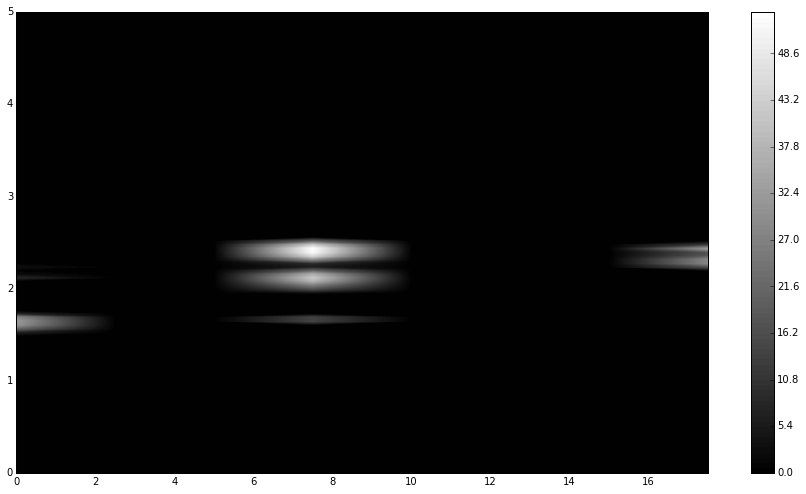

In [7]:
f0 = plt.figure(0, (15,8), facecolor='white')
ax0 = f0.add_axes([.1, .1, .8, .8])
contour0 = ax0.contourf(x, z, ext, 100, cmap=cm.gray)
ax0.set_ybound((0,5))
f0.colorbar(contour0, ax=ax0)

In [18]:
# The the adjoint results
fadj = "radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.adj"
print_head(fadj, Nlines=100)  



Showing head: radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.adj
	! SHDOMADJ optical property adjoint output
	!   X       Y       Z     ADEXTINCT   ADALBEDO   ADSINGSCAT(1..NSTSING,1..NRADDIR)
	0.0000  0.0000  0.0000 -7.220E-06  1.384E-06  2.540E-05  2.610E-05  8.162E-06
	0.0000  0.0000  0.0095 -2.529E-05  4.514E-06  8.070E-05  8.761E-05  2.636E-05
	0.0000  0.0000  0.0315 -4.138E-05  6.660E-06  1.110E-04  1.388E-04  3.794E-05
	0.0000  0.0000  0.0574 -5.251E-05  7.601E-06  1.131E-04  1.745E-04  4.170E-05
	0.0000  0.0000  0.0878 -7.434E-05  1.058E-05  1.803E-04  2.251E-04  4.762E-05
	0.0000  0.0000  0.1245 -9.725E-05  1.517E-05  3.012E-04  2.890E-04  5.036E-05
	0.0000  0.0000  0.1650 -1.076E-04  2.087E-05  4.663E-04  3.559E-04  4.724E-05
	0.0000  0.0000  0.2050 -1.844E-04  3.026E-05  7.619E-04  4.354E-04  4.552E-05
	0.0000  0.0000  0.2450 -2.578E-04  4.331E-05  1.200E-03  5.195E-04  3.654E-05
	0.0000  0.0000  0.2850 -2.246E-04  5.936E-05  1.716E-03  6.427E-04  3.027E-05
	0.0000  0.0000  0

In [9]:
# Read the adjoint file

cols = ['X', 'Y', 'Z', 'ADEXTINCT', "ADALBEDO"]
value_list = []
for line in open(fadj):
    if line[0] =='!':
        pass
    else:
        new = line.strip().split()
        value_list.append(new[:len(cols)])
        
values = np.array(value_list, dtype="f8").T
adjoint_dict = dict(zip(cols, values))


In [10]:
# Get values to plot
nx = np.unique(adjoint_dict['X']).size
nz = np.unique(adjoint_dict['Z']).size
x = adjoint_dict['X'].reshape(nx, nz)
z = adjoint_dict['Z'].reshape(nx, nz)
adj_ext = adjoint_dict['ADEXTINCT'].reshape(nx, nz)
adj_alb = adjoint_dict['ADALBEDO'].reshape(nx, nz)

print("maxes: {}, {}.".format(abs(adj_ext).max(),abs(adj_alb).max()))


maxes: 16.91, 0.501.


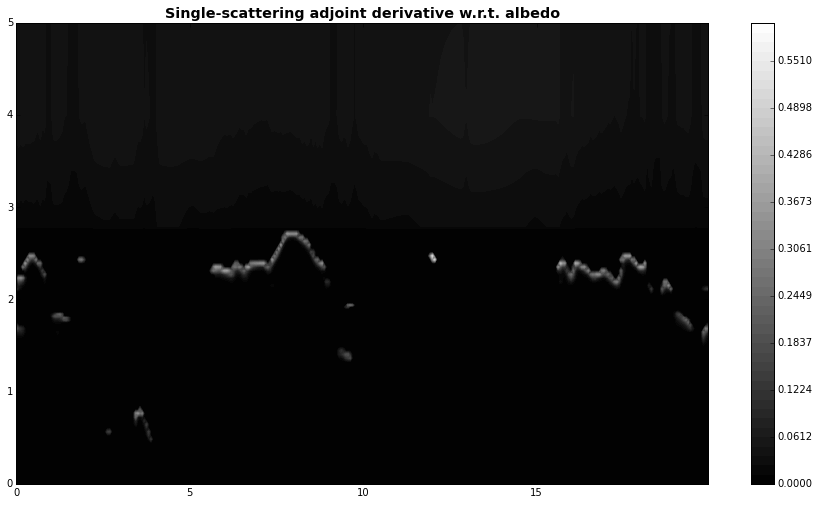

In [11]:
#plot the adjoint of the extinction
f1 = plt.figure(1, (15, 8), facecolor='white')
ax1 = f1.add_axes([.1, .1, .8, .8])
contour1 =ax1.contourf(x, z, adj_alb, levels=np.linspace(0, .6,50), cmap=cm.gray)
ax1.set_ybound(0,5)
f1.colorbar(contour1, ax=ax1)

ax1.set_title("Single-scattering adjoint derivative w.r.t. albedo", fontsize="x-large", fontweight="bold")

In [19]:
# The first adjoint radiance field
farad1 = "radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.arad"
print_head(farad1, Nlines=100)


Showing head: radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss1.arad
	! Polarized Spherical Harmonic Discrete Ordinate Radiative Transfer Radiance Output
	!  L= 15  M= 15  NLM=  256   NMU= 16  NPHI= 32  NANG=  354   NSH=   1757885
	!  NSTOKES=1   NX= 320   NY=   1   NZ=  85    NPTS=   27285   NCELLS=   26880
	!  PARTICLE_FILE=les0822nh15t13y89_ocaer1.part
	!  CORRELATED_K-DIST_FILE=NONE   NUM_G= 1
	!  SOURCE_TYPE=SOLAR               DELTA-M METHOD
	!  GRID_TYPE=EVEN (X,Y)    PROPERTY-FILE (Z)    INDEPENDENT_PIXEL=2
	!  SURFACE_TYPE=FIXED LAMBERTIAN         HORIZ_BOUNDARY_COND=0
	!  GROUND_ALBEDO=0.0500000  SKY_RAD= 0.00000E+00
	!  SOLAR_FLUX= 0.100000E+01   SOLAR_MU=-0.9221000   SOLAR_AZ= 339.400
	!  UNITS=WATTS/(M^2 MICRON STER)    WAVELENGTH=      0.65
	!  SPLITTING_ACCURACY= 0.300E-01   SPHERICAL_HARMONIC_ACCURACY= 0.300E-02
	!  SOLUTION_ACCURACY= 0.300E-04
	!  MAXIMUM_ITERATIONS=   0   NUMBER_ITERATIONS=   0
	!  RADIANCE AT Z= 15.000
	320    1    3 ! NXOUT, NYOUT, NRADDIR
	!  ID      m

In [13]:
# The second adjoint radiance field
farad2 = "radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss2.arad"
print_head(farad2)                


Showing head: radobs_les0822nh15t13y89_ocaer1_w0.646_ns1ss2.arad
	! Polarized Spherical Harmonic Discrete Ordinate Radiative Transfer Radiance Output
	!  L= 15  M= 15  NLM=  256   NMU= 16  NPHI= 32  NANG=  354   NSH=   2422485
	!  NSTOKES=1   NX= 320   NY=   1   NZ=  85    NPTS=   30052   NCELLS=   31290
	!  PARTICLE_FILE=les0822nh15t13y89_ocaer1.part
	!  CORRELATED_K-DIST_FILE=NONE   NUM_G= 1
	!  SOURCE_TYPE=SOLAR               DELTA-M METHOD
	!  GRID_TYPE=EVEN (X,Y)    PROPERTY-FILE (Z)    INDEPENDENT_PIXEL=2
	!  SURFACE_TYPE=FIXED LAMBERTIAN         HORIZ_BOUNDARY_COND=0
	!  GROUND_ALBEDO=0.0500000  SKY_RAD= 0.00000E+00
	!  SOLAR_FLUX= 0.100000E+01   SOLAR_MU=-0.9221000   SOLAR_AZ= 339.400




In [14]:
# A sample modis file
fmodis_blue = "les0822nh15t13_aer008_w0.646rad.modis"
print_head(fmodis_blue)

Showing head: les0822nh15t13_aer008_w0.646rad.modis
	40  40  23
	! Simulated MODIS reflectances from SHDOM radiance output
	! IA   Rad(1:Ncross)
	1 1.0000  0.00   0.00 20.000 20.000 ! idir, mu, theta, phi_shdom, size_cross, size_along
	1 0.0765 0.1141 0.2162 0.1455 0.1407 0.0961 0.0401 0.0496 0.0690 0.0696 0.0722 0.0709 0.0778 0.0677 0.0694 0.0692 0.0725 0.1055 0.0934 0.0724 0.0701 0.0680 0.0680 0.0679 0.0680 0.0682 0.0684 0.0691 0.0747 0.0888 0.1230 0.0937 0.1201 0.0896 0.0944 0.0857 0.0592 0.0672 0.0700 0.0722
	2 0.0702 0.0723 0.0972 0.0969 0.2869 0.2755 0.0567 0.0559 0.0687 0.0636 0.0761 0.0977 0.0996 0.1314 0.0961 0.0598 0.0686 0.0689 0.0840 0.0941 0.0648 0.0692 0.0710 0.0670 0.0679 0.0678 0.0682 0.0687 0.0697 0.0782 0.1025 0.0723 0.0575 0.0718 0.0841 0.0720 0.0803 0.0733 0.0694 0.0699
	3 0.0697 0.0700 0.0712 0.0723 0.1212 0.1625 0.0773 0.0977 0.0573 0.0622 0.0979 0.0866 0.1896 0.2539 0.1146 0.1198 0.1418 0.0673 0.0754 0.1100 0.0931 0.0671 0.0703 0.0683 0.0682 0.0679 0.0679 0.0683 

In [15]:
# Reflectance from the MODIS case, but at full 320 x 320 resolution 
fhres_blue = "les0822nh15t13_aer008_w0.646.ref"
print_head(fhres_blue)

Showing head: les0822nh15t13_aer008_w0.646.ref
	0   0 0.0499 0.1004 0.2231 0.0945 0.0426 0.1586 0.0464
	1   0 0.0495 0.1004 0.2272 0.0976 0.0393 0.2537 0.0463
	2   0 0.0493 0.1004 0.2193 0.0935 0.0390 0.2863 0.0463
	3   0 0.0493 0.1004 0.2151 0.0913 0.0391 0.2772 0.0463
	4   0 0.0498 0.1004 0.2003 0.0937 0.0394 0.2357 0.0462
	5   0 0.0533 0.1003 0.1858 0.0979 0.0399 0.1731 0.0462
	6   0 0.0583 0.1003 0.1592 0.1063 0.0407 0.1175 0.0461
	7   0 0.0602 0.1002 0.1362 0.1148 0.0413 0.0771 0.0460
	8   0 0.0602 0.1002 0.1257 0.1197 0.0413 0.0479 0.0459
	9   0 0.0602 0.1001 0.1255 0.1194 0.0413 0.0425 0.0459


